[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/027_pytorch_intro/pytorch_intro.ipynb)

In [116]:
import torch
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np
import pandas as pd

# Libreria para graficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import random


# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline


In [117]:

data = loadmat('smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')

dataset = data['dataset']

train_data = dataset['train'][0][0]
test_data = dataset['test'][0][0]


train_images = train_data['images'][0][0]
train_labels = train_data['labels'][0][0]
test_images = test_data['images'][0][0]
test_labels = test_data['labels'][0][0]

# Longitud total del emnist ((124800, 784), (124800,)) (train)
# Longitud total del emnist ((20800, 784), (20800,)) (test)

x_train= train_images[:70000, :]
# la fuanción ravel() es para convertir de una matriz unidimencional a un arreglo
y_train= train_labels[:70000].ravel()

x_test = test_images[:, :]
y_test = test_labels[:].ravel()
# # convirtiendo el rango de 1-26 a 0-25
y_train[y_train == 26] = 0
y_test[y_test == 26] = 0

# m = y_train.size


x_train.shape, y_train.shape

((70000, 784), (70000,))

In [118]:
x_test.shape, y_test.shape

((20800, 784), (20800,))

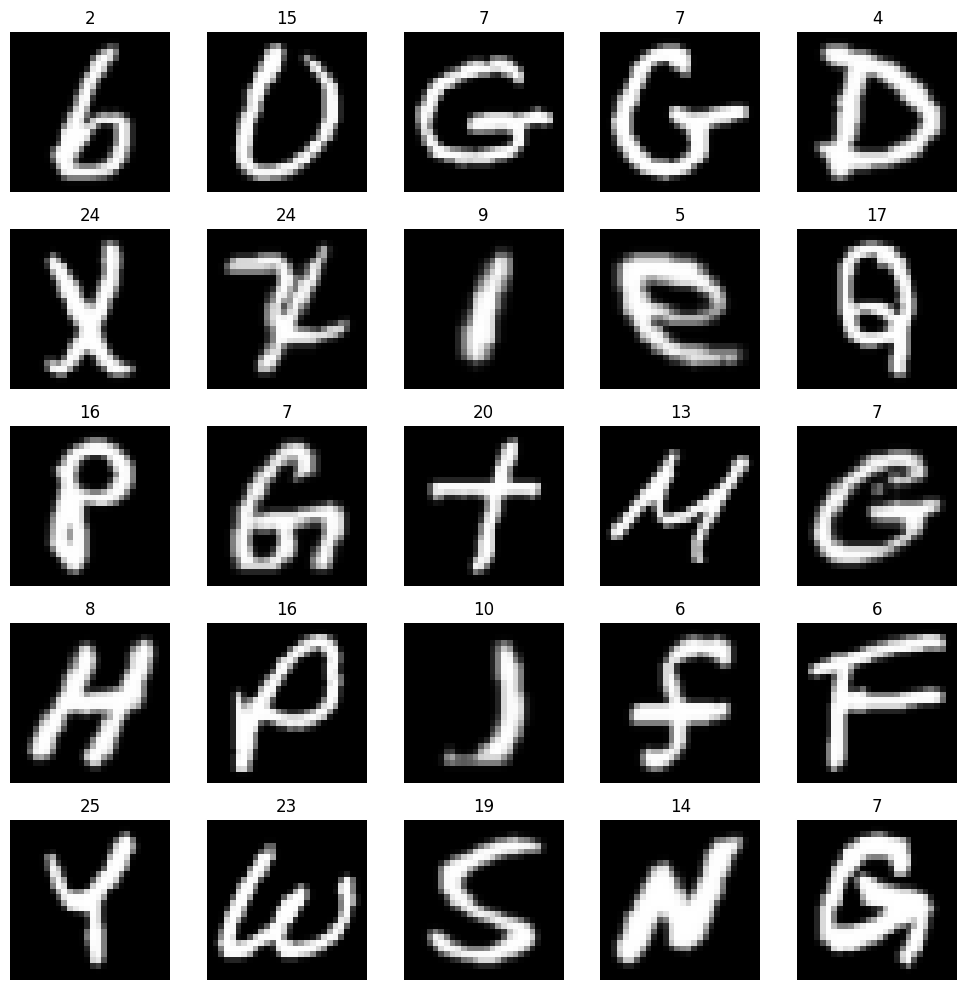

In [119]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(x_train)-1)
        img = x_train[ix]
        plt.imshow(img.reshape(28,28).T, cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [120]:
# normalizamos los datos

X_train, X_test, Y_train, Y_test = x_train[:] / 255., x_test[:] / 255., y_train[:60000].astype(np.int), y_test[60000:].astype(np.int)

<ipython-input-120-d38883502b1f>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train, X_test, Y_train, Y_test = x_train[:] / 255., x_test[:] / 255., y_train[:60000].astype(np.int), y_test[60000:].astype(np.int)


In [121]:
# función de pérdida y derivada

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [122]:
D_in, H1, H2, D_out = 784, 100,50 , 26  # Nuevas dimensiones

# Pesos y sesgos de las capas
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H1)),
          size = (D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)

w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(H1+H2)),
          size = (H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)

w3 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(H2+D_out)),
          size = (H2, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()


epochs = 700
lr = 0.8
log_each = 70
l = []
for e in range(1, epochs+1):

  # Mish

    # mish = torch.nn.Mish()
    # h = X_t.mm(w1) + b1
    # h_relu = mish(h) # relu
    # h_2 = h_relu.mm(w2) + b2
    # h_relu_2 = mish(h_2)
    # y_pred = h_relu_2.mm(w3) + b3

  # GELU
    # gelu = torch.nn.GELU()
    # h = X_t.mm(w1) + b1
    # h_relu = gelu(h) # relu
    # h_2 = h_relu.mm(w2) + b2
    # h_relu_2 = gelu(h_2)
    # y_pred = h_relu_2.mm(w3) + b3


  # Relu
    Relu = torch.nn.ReLU()
    h = X_t.mm(w1) + b1
    h_relu = Relu(h) # relu
    h_2 = h_relu.mm(w2) + b2
    h_relu_2 = Relu(h_2)
    y_pred = h_relu_2.mm(w3) + b3


    # forward
    # h = X_t.mm(w1) + b1
    # h_relu = h.clamp(min=0) # relu
    # h_2 = h_relu.mm(w2) + b2
    # h_relu_2 = h_2.clamp(min=0)
    # y_pred = h_relu_2.mm(w3) + b3

    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad
        w3 -= lr * w3.grad
        b3 -= lr * b3.grad
        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")



Epoch 70/700 Loss 2.00539
Epoch 140/700 Loss 1.47799
Epoch 210/700 Loss 1.21452
Epoch 280/700 Loss 1.05313
Epoch 350/700 Loss 0.94459
Epoch 420/700 Loss 0.86227
Epoch 490/700 Loss 0.79808
Epoch 560/700 Loss 0.75597
Epoch 630/700 Loss 0.71252
Epoch 700/700 Loss 0.67460


In [123]:
def evaluate(x):
    h = x.mm(w1) + b1
    h_relu = h.clamp(min=0)
    h_2 = h_relu.mm(w2) + b2
    h_relu_2 = h_2.clamp(min=0)
    y_pred = h_relu_2.mm(w3) + b3
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [124]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.8673076923076923

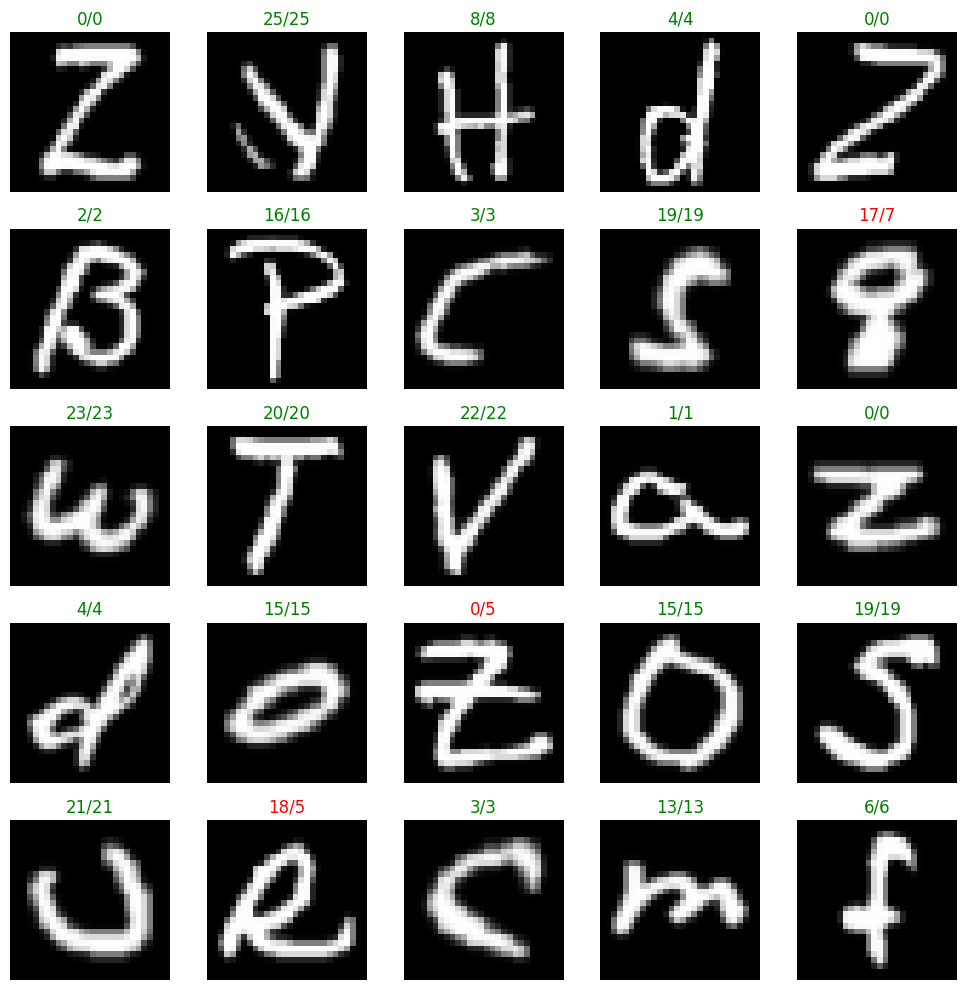

In [125]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28).T, cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

Como puedes observar, simplemente definiendo los `tensores` para los pesos y los datos y copiándolos a la GPU podemos definir el `grafo computacional` de manera dinámica aplicando operaciones sobre los tensores (multiplicamos por los pesos y sumamos el *bias*). Una vez tenemos la salida del `MLP` calculamos la función de pérdida y llamando a la función `backward` `Pytorch` se encarga de calcular todas las derivadas de manera automática. Una vez tenemos los gradientes con respecto a los pesos, podemos actualizarlos.

## Resumen

En este post hemos visto una introducción a `Pytorch`, un framework de `redes neuronales` muy utilizado a día de hoy. Hemos visto que `Pytorch` es muy similar a `NumPy` y comparten gran parte de su sintaxis, lo cual es una ventaja si ya sabemos trabajar con `NumPy`. Además, añade `autograd`, la capacidad de construir de manera dinámica un `grafo computacional` de manera que en cualquier momento podemos calcular derivadas con respecto a cualquier tensor de manera automática. Por último, hemos visto como podemos ejecutar todas estas operaciones en una GPU para acelerar el proceso de entrenamiento de nuestros modelos de `Deep Learning`. Este es el núcleo de `Pytorch`, sin embargo esta librería nos ofrece más funcionalidad, de la cual hablaremos más adelante, que nos será muy útil para diseñar, entrenar y poner a trabajar nuestras `redes neuronales`.